In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
def seed_everything(seed=2020):
    random.seed(seed)
    np.random.seed(seed)
seed_everything(42)

warnings.filterwarnings("ignore")
%matplotlib inline

# Pulsar star

In [27]:
data = pd.read_csv("../../data/pulsar_stars.csv")
data.head()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [28]:
data.shape

(17898, 9)

In [29]:
data.columns = data.columns.str.strip()
data.columns = ['IP Mean', 'IP Sd', 'IP Kurtosis', 'IP Skewness', 
              'DM-SNR Mean', 'DM-SNR Sd', 'DM-SNR Kurtosis', 'DM-SNR Skewness', 'target_class']

In [30]:
# data['target_class'].value_counts()
# view the percentage distribution of target_class column
data['target_class'].value_counts()/np.float(len(data))

0    0.908426
1    0.091574
Name: target_class, dtype: float64

In [31]:
df_ab = data[data['target_class']==1]
df_nnorm = data[data['target_class']!=1]
df_ab.head()

,IP Mean,IP Sd,IP Kurtosis,IP Skewness,DM-SNR Mean,DM-SNR Sd,DM-SNR Kurtosis,DM-SNR Skewness,target_class
19,99.367188,41.572202,1.547197,4.154106,27.555184,61.719016,2.208808,3.662680,1
42,120.554688,45.549905,0.282924,0.419909,1.358696,13.079034,13.312141,212.597029,1
61,27.765625,28.666042,5.770087,37.419009,73.112876,62.070220,1.268206,1.082920,1
92,23.625000,29.948654,5.688038,35.987172,146.568562,82.394624,-0.274902,-1.121848,1
93,94.585938,35.779823,1.187309,3.687469,6.071070,29.760400,5.318767,28.698048,1


In [32]:
from sklearn.preprocessing import MinMaxScaler

scaler    = MinMaxScaler()
df_values = df_ab.copy()
column_list = list(df_values.columns) 
df_values = df_values.drop(['target_class'], axis=1)
df_norm   = scaler.fit_transform(df_values)

In [33]:
# X = df_norm.drop(['target_class'],axis=1)
# y= df_norm['target_class']

In [34]:
column_list

['IP Mean',
 'IP Sd',
 'IP Kurtosis',
 'IP Skewness',
 'DM-SNR Mean',
 'DM-SNR Sd',
 'DM-SNR Kurtosis',
 'DM-SNR Skewness',
 'target_class']

In [35]:
df_norm.shape[1]

8

# Autoencoder

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler

from keras.models import Sequential, Model
from keras.layers import Dense, BatchNormalization, Dropout, Flatten, Input
from keras import backend as K
import keras
from matplotlib.colors import LogNorm

In [37]:
n_features = df_norm.shape[1]

dim = 15

def build_model(dropout_rate=0.15, activation='tanh'):
    main_input = Input(shape=(n_features, ), name='main_input')
    
    x = Dense(dim*2, activation=activation)(main_input)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    x = Dense(dim*2, activation=activation)(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate/2)(x)
    
    x = Dense(dim, activation=activation)(x)
    x = Dropout(dropout_rate/4)(x)

    encoded = Dense(n_features, activation='tanh')(x)

    input_encoded = Input(shape=(n_features, ))
    
    x = Dense(dim, activation=activation)(input_encoded)
    x = Dense(dim, activation=activation)(x)
    x = Dense(dim*2, activation=activation)(x)
    
    decoded = x = Dense(n_features, activation='linear')(x)

    encoder = Model(main_input, encoded, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(main_input, decoder(encoder(main_input)), name="autoencoder")
    return encoder, decoder, autoencoder

K.clear_session()
c_encoder, c_decoder, c_autoencoder = build_model()
c_autoencoder.compile(optimizer='nadam', loss='mse')

c_autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 8)]               0         
_________________________________________________________________
encoder (Functional)         (None, 8)                 2033      
_________________________________________________________________
decoder (Functional)         (None, 8)                 1103      
Total params: 3,136
Trainable params: 3,016
Non-trainable params: 120
_________________________________________________________________


Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.2284
Epoch 2/50
1/1 [==============================] - 0s 5ms/step - loss: 0.2105
Epoch 3/50
1/1 [==============================] - 0s 6ms/step - loss: 0.2003
Epoch 4/50
1/1 [==============================] - 0s 6ms/step - loss: 0.1896
Epoch 5/50
1/1 [==============================] - 0s 6ms/step - loss: 0.1800
Epoch 6/50
1/1 [==============================] - 0s 6ms/step - loss: 0.1711
Epoch 7/50
1/1 [==============================] - 0s 6ms/step - loss: 0.1641
Epoch 8/50
1/1 [==============================] - 0s 6ms/step - loss: 0.1541
Epoch 9/50
1/1 [==============================] - 0s 6ms/step - loss: 0.1460
Epoch 10/50
1/1 [==============================] - 0s 7ms/step - loss: 0.1375
Epoch 11/50
1/1 [==============================] - 0s 6ms/step - loss: 0.1304
Epoch 12/50
1/1 [==============================] - 0s 6ms/step - loss: 0.1218
Epoch 13/50
1/1 [==============================] - 0s 5ms/step - loss: 0.1

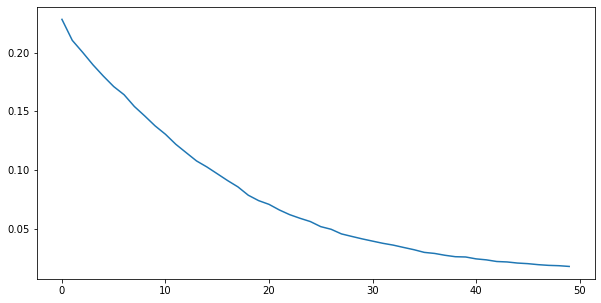

In [38]:
%%time
epochs = 50
batch_size = 9548
history = c_autoencoder.fit(df_norm, df_norm,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    verbose=1)

loss_history = history.history['loss']
plt.figure(figsize=(10, 5))
plt.plot(loss_history);

In [39]:
ae = c_encoder.predict(df_norm)
ae.shape

(1639, 8)

In [40]:
ae

array([[ 0.10203686,  0.18994889, -0.24651714, ..., -0.27151108,
        -0.09968395, -0.01604798],
       [-0.20908518, -0.63112783, -0.0388834 , ..., -0.14156352,
        -0.3797776 , -0.43705288],
       [ 0.3987259 ,  0.8972068 , -0.07230467, ..., -0.50539047,
         0.4286167 ,  0.56090224],
       ...,
       [ 0.149443  ,  0.3945674 , -0.22384107, ..., -0.3435636 ,
        -0.05176032,  0.06504654],
       [ 0.47558627,  0.94502336,  0.08771742, ..., -0.56261206,
         0.5898076 ,  0.5446127 ],
       [ 0.2536585 ,  0.6065965 ,  0.09979971, ..., -0.36783707,
         0.25208637, -0.21644224]], dtype=float32)

In [41]:
df_ae = pd.DataFrame(ae)
df_ae['target_class'] = 1

In [42]:
df_ae.columns = column_list
df_ae.head(10)

,IP Mean,IP Sd,IP Kurtosis,IP Skewness,DM-SNR Mean,DM-SNR Sd,DM-SNR Kurtosis,DM-SNR Skewness,target_class
0,0.102037,0.189949,-0.246517,0.310164,-0.528513,-0.271511,-0.099684,-0.016048,1
1,-0.209085,-0.631128,-0.038883,0.284179,-0.485053,-0.141564,-0.379778,-0.437053,1
2,0.398726,0.897207,-0.072305,0.234846,-0.283689,-0.505390,0.428617,0.560902,1
3,0.462421,0.934602,0.113304,0.385450,-0.183525,-0.563117,0.540857,0.462234,1
4,0.000926,-0.245770,-0.122442,0.255142,-0.519066,-0.184713,-0.233905,-0.089061,1
5,0.065861,-0.033293,-0.208664,0.350319,-0.563870,-0.188977,-0.125620,-0.150631,1
6,0.279239,0.766321,-0.237769,0.148359,-0.381254,-0.460565,0.174575,0.447076,1
7,0.385343,0.907654,-0.197468,0.131889,-0.328100,-0.506239,0.394473,0.642260,1
8,0.423479,0.825983,0.316836,0.571771,-0.080430,-0.447552,0.370548,0.061659,1
9,0.481886,0.920173,0.238219,0.498074,-0.103355,-0.555176,0.515402,0.293460,1


In [43]:
df_nvalues = df_nnorm.drop(['target_class'], axis=1)
scaled_nnorm   = scaler.fit_transform(df_nvalues)
df_scaler_nnorm = pd.DataFrame(scaled_nnorm, index=df_nvalues.index, columns=df_nvalues.columns)
df_scaler_nnorm['target_class'] = data.target_class
df_scaler_nnorm.head()

,IP Mean,IP Sd,IP Kurtosis,IP Skewness,DM-SNR Mean,DM-SNR Sd,DM-SNR Kurtosis,DM-SNR Skewness,target_class
0,0.703234,0.385060,0.246396,0.040963,0.013382,0.113681,0.294986,0.063890,0
1,0.486282,0.430702,0.351456,0.047884,0.006560,0.072524,0.364015,0.108443,0
2,0.489177,0.151868,0.330142,0.106624,0.013030,0.139188,0.288624,0.054610,0
3,0.681498,0.406388,0.271338,0.043341,0.015368,0.131583,0.266348,0.046581,0
4,0.407714,0.170854,0.371803,0.109336,0.004327,0.039684,0.462029,0.213369,0


In [44]:
df_train = pd.concat([df_ae, df_scaler_nnorm], ignore_index=True)
df_train.shape

(17898, 9)

In [45]:
X = df_train.drop(['target_class'], axis=1)
y = df_train['target_class']

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [47]:
# Model

In [48]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve,auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import matthews_corrcoef, confusion_matrix,precision_recall_curve,auc,f1_score,roc_auc_score,roc_curve,recall_score,classification_report 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


In [49]:

def model(algorithm,dtrain_x,dtrain_y,dtest_x,dtest_y):
    
    print ("MODEL - OUTPUT")
    print ("*****************************************************************************************")
    algorithm.fit(dtrain_x,dtrain_y)
    predictions = algorithm.predict(dtest_x)
    
    print (algorithm)
    print ("\naccuracy_score :",accuracy_score(dtest_y,predictions))
    print ("\nrecall score:\n",(recall_score(dtest_y,predictions)))
    print ("\nf1 score:\n",(f1_score(dtest_y,predictions)))
#     print ("\nclassification report :\n",(classification_report(dtest_y,predictions)))
    print ("\nmatthews_corrcoef:\n", (matthews_corrcoef(dtest_y, predictions)))
    #cross validation
    
    # Graph
    plt.figure(figsize=(13,10))
    plt.subplot(221)
    sns.heatmap(confusion_matrix(dtest_y,predictions),annot=True,fmt = "d",linecolor="k",linewidths=3)
    plt.title("CONFUSION MATRIX",fontsize=20)
    
    predicting_probabilites = algorithm.predict_proba(dtest_x)[:,1]
    fpr,tpr,thresholds = roc_curve(dtest_y,predicting_probabilites)
    plt.subplot(222)
    plt.plot(fpr,tpr,label = ("Area_under the curve :",auc(fpr,tpr)),color = "r")
    plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
    plt.legend(loc = "best")
    plt.title("ROC - CURVE & AREA UNDER CURVE",fontsize=20)


MODEL - OUTPUT
*****************************************************************************************
LogisticRegression()

accuracy_score : 1.0

recall score:
 1.0

f1 score:
 1.0

matthews_corrcoef:
 1.0


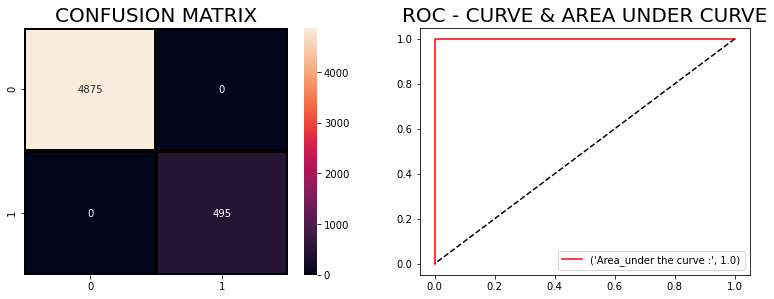

In [50]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
model(clf ,X_train,y_train,X_test,y_test)

MODEL - OUTPUT
*****************************************************************************************
DecisionTreeClassifier()

accuracy_score : 0.9998137802607077

recall score:
 0.997979797979798

f1 score:
 0.9989888776541962

matthews_corrcoef:
 0.9988869436322848


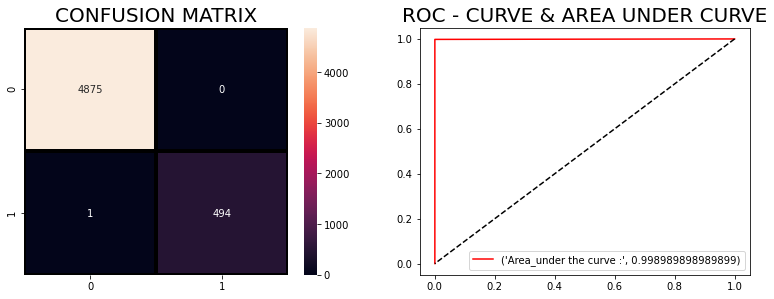

In [51]:
clf = DecisionTreeClassifier()
model(clf ,X_train,y_train,X_test,y_test)

MODEL - OUTPUT
*****************************************************************************************
SVC(probability=True)

accuracy_score : 1.0

recall score:
 1.0

f1 score:
 1.0

matthews_corrcoef:
 1.0


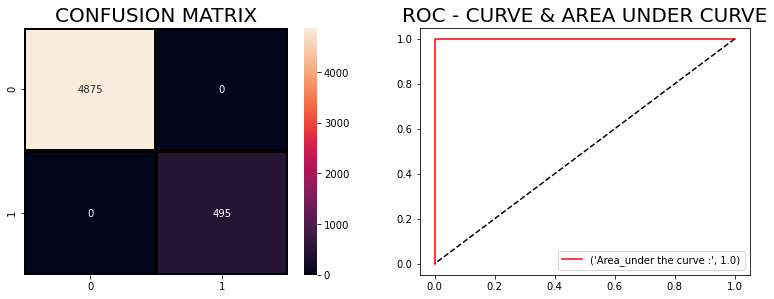

In [52]:
svc=SVC(probability=True) 

model(svc ,X_train,y_train,X_test,y_test)

MODEL - OUTPUT
*****************************************************************************************
RandomForestClassifier()

accuracy_score : 1.0

recall score:
 1.0

f1 score:
 1.0

matthews_corrcoef:
 1.0


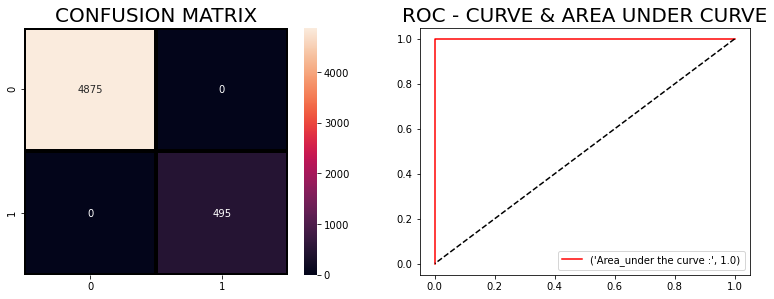

In [53]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
model(clf ,X_train,y_train,X_test,y_test)